In [2]:
import pandas as pd


In [3]:
health_df = pd.read_csv("data/interim/health.csv")
health_df = health_df[health_df["status"] != "TERMINATED"]
health_df.shape


(3465, 26)

In [4]:
# Extract metadata
abstracts = health_df["objective"].to_numpy()
titles = health_df["title"].to_numpy()
text = titles + "\n" + abstracts


In [5]:
from sentence_transformers import SentenceTransformer

# Create an embedding for each abstract
embedding_model = SentenceTransformer("NovaSearch/stella_en_400M_v5", trust_remote_code=True)
embeddings = embedding_model.encode(text, show_progress_bar=True)


Some weights of the model checkpoint at NovaSearch/stella_en_400M_v5 were not used when initializing NewModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/109 [00:00<?, ?it/s]

In [6]:
embeddings.shape


(3465, 1024)

In [7]:
from umap import UMAP

# We reduce the input embeddings from 384 dimensions to 5 dimensions
umap_model = UMAP(
    n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42
    )
reduced_embeddings = umap_model.fit_transform(embeddings)


/storage/projects/climate_llm/Modern-Analytics/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/storage/projects/climate_llm/Modern-Analytics/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/storage/projects/climate_llm/Modern-Analytics/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [8]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=25,
    metric="euclidean",
    cluster_selection_method="eom",
    # min_samples=15,
).fit(reduced_embeddings)

clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))


/storage/projects/climate_llm/Modern-Analytics/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/storage/projects/climate_llm/Modern-Analytics/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


24

In [9]:
import numpy as np
# Print first three documents in cluster 0
cluster = 0

for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")
    

OphtiMedRx is an ophthalmic drug development start-up company led by a team of exceptional women physicians and scientists led by Dr. Dana Rabinovich. OphtiMedRx is developing a novel drug for treating dry age-related macular degeneration (AMD), a leading cause of vision loss. There is no available ... 

StemSight is developing off-the-shelf stem cell therapies to cure blindness. We aim to solve the global shortage of corneal donor tissue by producing high-quality tissue products using allogeneic induced pluripotent stem cells (iPSCs) and biomaterials. Our lead product is aimed at a rare but severe ... 

I am the CEO and Cofounder of SeaBeLife, a French biotechnology company developing First-In-Class drugs to treat severe pathologies affecting our vital organs for which there are no effective treatments. We develop an innovative therapeutic approach protected by 4 patents and with a lead program to ... 



In [10]:
# Check clusters
# import pandas as pd
# import matplotlib.pyplot as plt

# Reduce 384-dimensional embeddings to two dimensions for easier visualization
# reduced_embeddings = UMAP(
#     n_components=2, min_dist=0.0, metric="cosine", random_state=42
# ).fit_transform(embeddings)

# Create dataframe
# df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
# df["title"] = titles
# df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
# to_plot = df.loc[df.cluster != "-1", :]
# outliers = df.loc[df.cluster == "-1", :]

# print(to_plot.shape)
# print(outliers.shape)

# Plot outliers and non-outliers separately
# plt.scatter(outliers.x, outliers.y, alpha=0.05, s=2, c="grey")
# plt.scatter(to_plot.x, to_plot.y, c=to_plot.cluster.astype(int),
            # alpha=0.6, s=2, cmap="tab20b"
# )
# plt.axis("off")


In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

stopwords = list(stopwords.words("english")) + ["project", "health", "research", "medical"]
vectorizer_model = CountVectorizer(stop_words=stopwords, min_df=2, ngram_range=(1, 2))


In [12]:
from transformers import pipeline
from bertopic.representation import TextGeneration
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
# from spacy.cli import download

# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
# download("en_core_web_sm")
pos_model = PartOfSpeech(
    "/home/gpham/.local/lib/python3.10/site-packages/en_core_sci_lg/en_core_sci_lg-0.5.4"
    )

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.2)

# Flan-t5
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
# Update our topic representations using Flan-T5
generator = pipeline("text2text-generation", model="google/flan-t5-small")
flant5_model = TextGeneration(
    generator, prompt=prompt, doc_length=350, tokenizer="whitespace"
)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    # "Flan-t5": flant5_model,
    "MMR": mmr_model,
    "POS": pos_model,
}


Device set to use cuda:0


In [13]:
from bertopic import BERTopic

# Train our model with our previously defined models
# topic_model = BERTopic(
#     embedding_model=embedding_model,
#     umap_model=umap_model,
#     hdbscan_model=hdbscan_model,
#     verbose=True
# ).fit(abstracts, embeddings)

topic_model = BERTopic(
  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True,
  language="english"
)

topics, probs = topic_model.fit_transform(text, embeddings)


2025-05-26 12:57:47,142 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


2025-05-26 12:58:06,443 - BERTopic - Dimensionality - Completed ✓
2025-05-26 12:58:06,446 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-26 12:58:06,514 - BERTopic - Cluster - Completed ✓
2025-05-26 12:58:06,518 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-26 12:58:29,932 - BERTopic - Representation - Completed ✓


In [14]:
topic_model.get_topic_info()


,Topic,Count,Name,Representation,KeyBERT,MMR,POS,Representative_Docs
0,-1,949,-1_new_data_based_brain,"[new, data, based, brain, development, human, ...","[ai, brain, approaches, clinical, patients, ai...","[new, data, brain, disease, develop, clinical,...","[new, data, brain, development, human, high, d...",[Virtual Brain Twin for personalised treatment...
1,0,694,0_cancer_cell_cells_tumor,"[cancer, cell, cells, tumor, therapy, immune, ...","[cancer cells, immunotherapy, tumours, tumors,...","[cancer, cell, cells, tumor, tumour, therapies...","[cancer, cell, cells, tumor, therapy, immune, ...",[Cancer cell plasticity on targeted therapy\nN...
2,1,258,1_viral_virus_malaria_vaccine,"[viral, virus, malaria, vaccine, viruses, infe...","[sars cov, antiviral, sars, vaccines, vaccine,...","[virus, malaria, vaccine, viruses, antiviral, ...","[viral, virus, malaria, vaccine, viruses, infe...",[Respiratory Host-Pathogen Interaction\nLower ...
3,2,195,2_social_policy_pandemic_political,"[social, policy, pandemic, political, mental, ...","[19 pandemic, covid 19, covid, eu, pandemic, i...","[social, policy, pandemic, eu, public, covid, ...","[social, policy, pandemic, political, mental, ...","[VET PARTICIPATION, RETENTION, AND EDUCATIONAL..."
4,3,167,3_cancer_imaging_ai_breast,"[cancer, imaging, ai, breast, detection, time,...","[breast cancer, biopsy, diagnostics, imaging, ...","[cancer, imaging, ai, breast, detection, bioma...","[cancer, imaging, breast, detection, time, dia...",[Surface-enhanced Raman spectroscopy in liquid...
5,4,144,4_ad_disease_brain_protein,"[ad, disease, brain, protein, alzheimer, micro...","[microglia, neuroinflammation, neurodegenerati...","[alzheimer, microglia, neurodegenerative, alzh...","[disease, brain, protein, microglia, neurodege...",[Deciphering the microglia-neuron interactions...
6,5,106,5_food_sustainable_production_aquaculture,"[food, sustainable, production, aquaculture, c...","[food systems, food system, sustainable food, ...","[food, sustainable, aquaculture, food systems,...","[food, sustainable, production, aquaculture, c...",[On a Quest for Data-Driven Innovations to fue...
7,6,94,6_bone_tissue_pain_bioprinting,"[bone, tissue, pain, bioprinting, oa, 3d, impl...","[bone regeneration, 3d bioprinting, bioprintin...","[bone, bioprinting, oa, implants, cartilage, r...","[bone, tissue, pain, bioprinting, implants, re...",[Drug solution for bone fracture nonunions\nBo...
8,7,90,7_bacteria_antibiotics_bacterial_resistance,"[bacteria, antibiotics, bacterial, resistance,...","[antimicrobial resistance, antibiotic resistan...","[bacteria, antibiotics, bacterial, antibiotic,...","[bacteria, antibiotics, bacterial, resistance,...",[Advanced Multidisciplinary Research for Antim...
9,8,89,8_gut_ibd_microbiome_microbiota,"[gut, ibd, microbiome, microbiota, intestinal,...","[gut microbiome, gut microbiota, microbiome, g...","[gut, ibd, microbiome, microbiota, intestinal,...","[gut, microbiome, microbiota, intestinal, host...",[Mechanistic study of gut microbial biotransfo...


In [15]:
topic_model.visualize_documents(
    text,
    reduced_embeddings=reduced_embeddings,
    hide_document_hover=True,
    hide_annotations=True,
)


In [16]:
new_topics = topic_model.reduce_outliers(
    text, topics, strategy="c-tf-idf", threshold=0.2
)

topic_model.update_topics(text, topics=new_topics)


2025-05-26 12:58:31,226 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [17]:
topic_model.get_topic_info()


,Topic,Count,Name,Representation,KeyBERT,MMR,POS,Representative_Docs
0,-1,812,-1_the_and_of_to,"[the, and, of, to, in, for, will, is, with, that]","[ai, brain, approaches, clinical, patients, ai...","[new, data, brain, disease, develop, clinical,...","[new, data, brain, development, human, high, d...",[Virtual Brain Twin for personalised treatment...
1,0,704,0_the_of_to_and,"[the, of, to, and, cancer, in, cell, cells, wi...","[cancer cells, immunotherapy, tumours, tumors,...","[cancer, cell, cells, tumor, tumour, therapies...","[cancer, cell, cells, tumor, therapy, immune, ...",[Cancer cell plasticity on targeted therapy\nN...
2,1,263,1_the_and_of_to,"[the, and, of, to, in, will, for, viral, virus...","[sars cov, antiviral, sars, vaccines, vaccine,...","[virus, malaria, vaccine, viruses, antiviral, ...","[viral, virus, malaria, vaccine, viruses, infe...",[Respiratory Host-Pathogen Interaction\nLower ...
3,2,200,2_and_the_of_health,"[and, the, of, health, to, in, social, on, wil...","[19 pandemic, covid 19, covid, eu, pandemic, i...","[social, policy, pandemic, eu, public, covid, ...","[social, policy, pandemic, political, mental, ...","[VET PARTICIPATION, RETENTION, AND EDUCATIONAL..."
4,3,177,3_the_and_of_cancer,"[the, and, of, cancer, for, to, in, imaging, i...","[breast cancer, biopsy, diagnostics, imaging, ...","[cancer, imaging, ai, breast, detection, bioma...","[cancer, imaging, breast, detection, time, dia...",[Surface-enhanced Raman spectroscopy in liquid...
5,4,153,4_ad_the_of_in,"[ad, the, of, in, and, disease, to, brain, is,...","[microglia, neuroinflammation, neurodegenerati...","[alzheimer, microglia, neurodegenerative, alzh...","[disease, brain, protein, microglia, neurodege...",[Deciphering the microglia-neuron interactions...
6,5,112,5_food_and_the_of,"[food, and, the, of, to, sustainable, will, in...","[food systems, food system, sustainable food, ...","[food, sustainable, aquaculture, food systems,...","[food, sustainable, production, aquaculture, c...",[On a Quest for Data-Driven Innovations to fue...
7,6,96,6_bone_the_and_of,"[bone, the, and, of, for, to, tissue, in, pain...","[bone regeneration, 3d bioprinting, bioprintin...","[bone, bioprinting, oa, implants, cartilage, r...","[bone, tissue, pain, bioprinting, implants, re...",[Drug solution for bone fracture nonunions\nBo...
8,7,99,7_the_of_antibiotics_resistance,"[the, of, antibiotics, resistance, antibiotic,...","[antimicrobial resistance, antibiotic resistan...","[bacteria, antibiotics, bacterial, antibiotic,...","[bacteria, antibiotics, bacterial, resistance,...",[Advanced Multidisciplinary Research for Antim...
9,8,100,8_gut_the_and_microbiome,"[gut, the, and, microbiome, of, in, to, microb...","[gut microbiome, gut microbiota, microbiome, g...","[gut, ibd, microbiome, microbiota, intestinal,...","[gut, microbiome, microbiota, intestinal, host...",[Mechanistic study of gut microbial biotransfo...


In [18]:
topic_model.visualize_documents(
    text,
    reduced_embeddings=reduced_embeddings,
    hide_document_hover=True,
    hide_annotations=True,
)


In [19]:
# Reduce outliers using the `probabilities` strategy
new_topics = topic_model.reduce_outliers(
    text, topics, probabilities=probs, strategy="distributions"
)


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


In [20]:
topic_model.update_topics(text, topics=new_topics)


2025-05-26 12:58:34,246 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [21]:
topic_model.get_topic_info()


,Topic,Count,Name,Representation,KeyBERT,MMR,POS,Representative_Docs
0,0,916,0_the_of_to_and,"[the, of, to, and, in, cell, cancer, will, cel...","[cancer cells, immunotherapy, tumours, tumors,...","[cancer, cell, cells, tumor, tumour, therapies...","[cancer, cell, cells, tumor, therapy, immune, ...",[Cancer cell plasticity on targeted therapy\nN...
1,1,309,1_the_and_of_to,"[the, and, of, to, in, will, for, viral, with,...","[sars cov, antiviral, sars, vaccines, vaccine,...","[virus, malaria, vaccine, viruses, antiviral, ...","[viral, virus, malaria, vaccine, viruses, infe...",[Respiratory Host-Pathogen Interaction\nLower ...
2,2,301,2_and_the_of_to,"[and, the, of, to, in, health, social, on, wil...","[19 pandemic, covid 19, covid, eu, pandemic, i...","[social, policy, pandemic, eu, public, covid, ...","[social, policy, pandemic, political, mental, ...","[VET PARTICIPATION, RETENTION, AND EDUCATIONAL..."
3,3,293,3_the_and_of_to,"[the, and, of, to, for, in, cancer, is, with, ...","[breast cancer, biopsy, diagnostics, imaging, ...","[cancer, imaging, ai, breast, detection, bioma...","[cancer, imaging, breast, detection, time, dia...",[Surface-enhanced Raman spectroscopy in liquid...
4,4,194,4_the_of_in_ad,"[the, of, in, ad, and, to, disease, brain, wil...","[microglia, neuroinflammation, neurodegenerati...","[alzheimer, microglia, neurodegenerative, alzh...","[disease, brain, protein, microglia, neurodege...",[Deciphering the microglia-neuron interactions...
5,5,127,5_food_and_the_of,"[food, and, the, of, to, sustainable, in, will...","[food systems, food system, sustainable food, ...","[food, sustainable, aquaculture, food systems,...","[food, sustainable, production, aquaculture, c...",[On a Quest for Data-Driven Innovations to fue...
6,6,118,6_bone_the_and_of,"[bone, the, and, of, to, for, tissue, in, will...","[bone regeneration, 3d bioprinting, bioprintin...","[bone, bioprinting, oa, implants, cartilage, r...","[bone, tissue, pain, bioprinting, implants, re...",[Drug solution for bone fracture nonunions\nBo...
7,7,116,7_the_of_antibiotic_and,"[the, of, antibiotic, and, to, antibiotics, re...","[antimicrobial resistance, antibiotic resistan...","[bacteria, antibiotics, bacterial, antibiotic,...","[bacteria, antibiotics, bacterial, resistance,...",[Advanced Multidisciplinary Research for Antim...
8,8,122,8_gut_and_the_of,"[gut, and, the, of, in, microbiome, to, microb...","[gut microbiome, gut microbiota, microbiome, g...","[gut, ibd, microbiome, microbiota, intestinal,...","[gut, microbiome, microbiota, intestinal, host...",[Mechanistic study of gut microbial biotransfo...
9,9,104,9_plant_the_of_and,"[plant, the, of, and, to, in, plants, will, cl...","[arabidopsis, plant, plants, crop, crops, seed...","[plant, plants, crop, drought, species, climat...","[plant, plants, crop, climate, drought, specie...",[From wild to crop: unravelling the impact of ...


In [22]:
topic_model.visualize_documents(
    text,
    reduced_embeddings=reduced_embeddings,
    hide_document_hover=True,
    hide_annotations=True,
)


In [23]:
topic_labels = {
    22: "Sustainable Pharmaceutical Manufacturing Technologies",
    21: "Chronic Kidney Disease and Organoids",
    20: "Retinal and Ocular Disease Mechanisms and Therapies",
    19: "Cancer Prevention and Patient-Centered Care",
    18: "Infectious Disease Dynamics and Pandemic Response",
    17: "Catalysis and Synthetic Organic Chemistry",
    16: "Diabetes Monitoring and Hormonal Regulation Methods",
    15: "Brain Sensory and Cognitive Processing",
    14: "NAFLD and Translational Liver Research",
    13: "Regenerative Cardiac Models and Therapeutics",
    12: "Trustworthy AI and Data Privacy in Digital Health",
    11: "Next-Generation Cardiovascular Diagnostics and Therapies",
    10: "Neuromodulation and Neurotechnology Therapies",
    9: "Molecular and Ecological Plant Adaptation",
    8: "Precision Medicine and Therapeutics for Gut Microbiome Disorders",
    7: "Holistic Approaches to Antimicrobial and Antibiotic Resistance",
    6: "Bone Bioprinting and Regenerative Implant Technologies",
    5: "Sustainable Food Systems and Nutritional Innovations",
    4: "Molecular Mechanisms and Innovative Treatments for Neurodegeneration",
    3: "Multimodal Cancer Imaging and Diagnostics Technologies",
    2: "Digital, Social, and Policy Innovations in Health",
    1: "Innovative Vaccines, Antivirals, and Diagnostics Tools",
    0: "Cancer Immunotherapy and Tumor Biology",
}

In [24]:
topic_model.set_topic_labels(topic_labels)


In [33]:
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(embeddings)


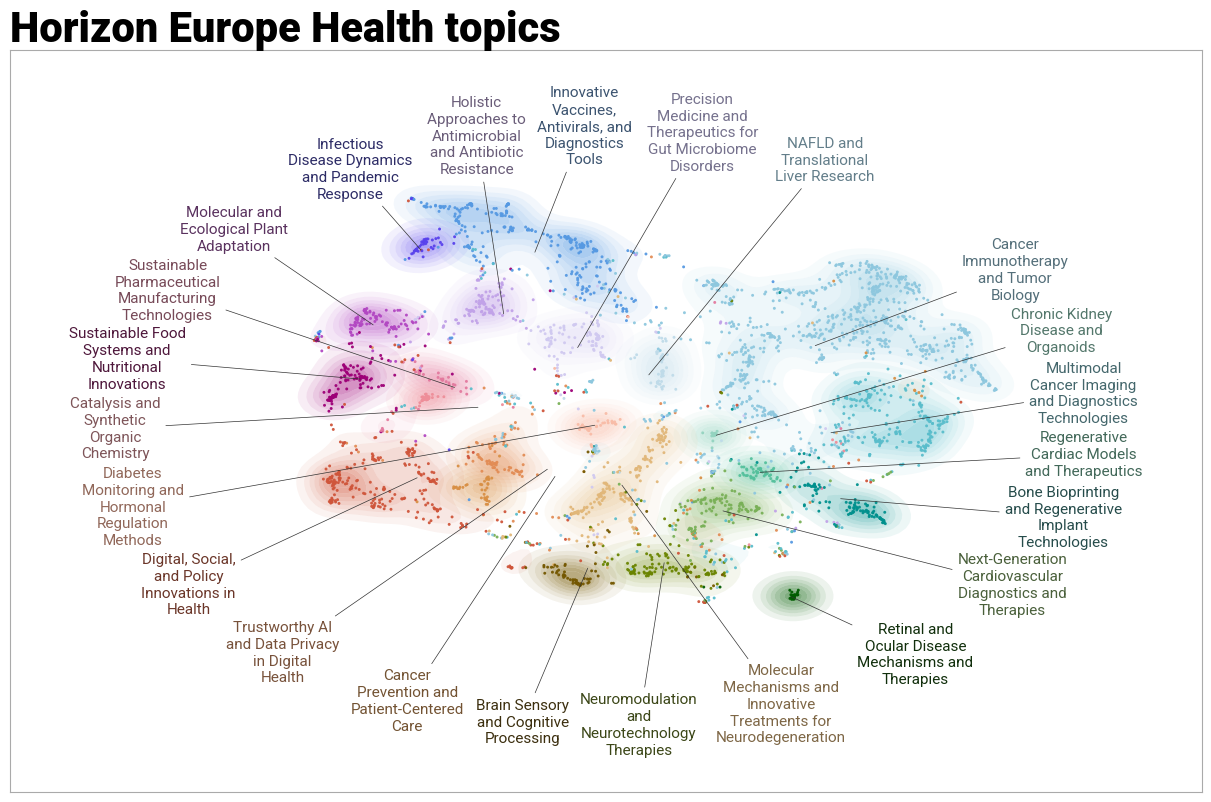

In [49]:
fig = topic_model.visualize_document_datamap(
    titles,
    title="Horizon Europe Health topics",
    # subtitle="",
    custom_labels=True,
    reduced_embeddings=reduced_embeddings,
    datamap_kwds={
        "label_font_size": 11,
        "label_linespacing": 1.25,
        "label_margin_factor": 1.0,
    },
)

fig.savefig("figures/doc_map.png", bbox_inches="tight")


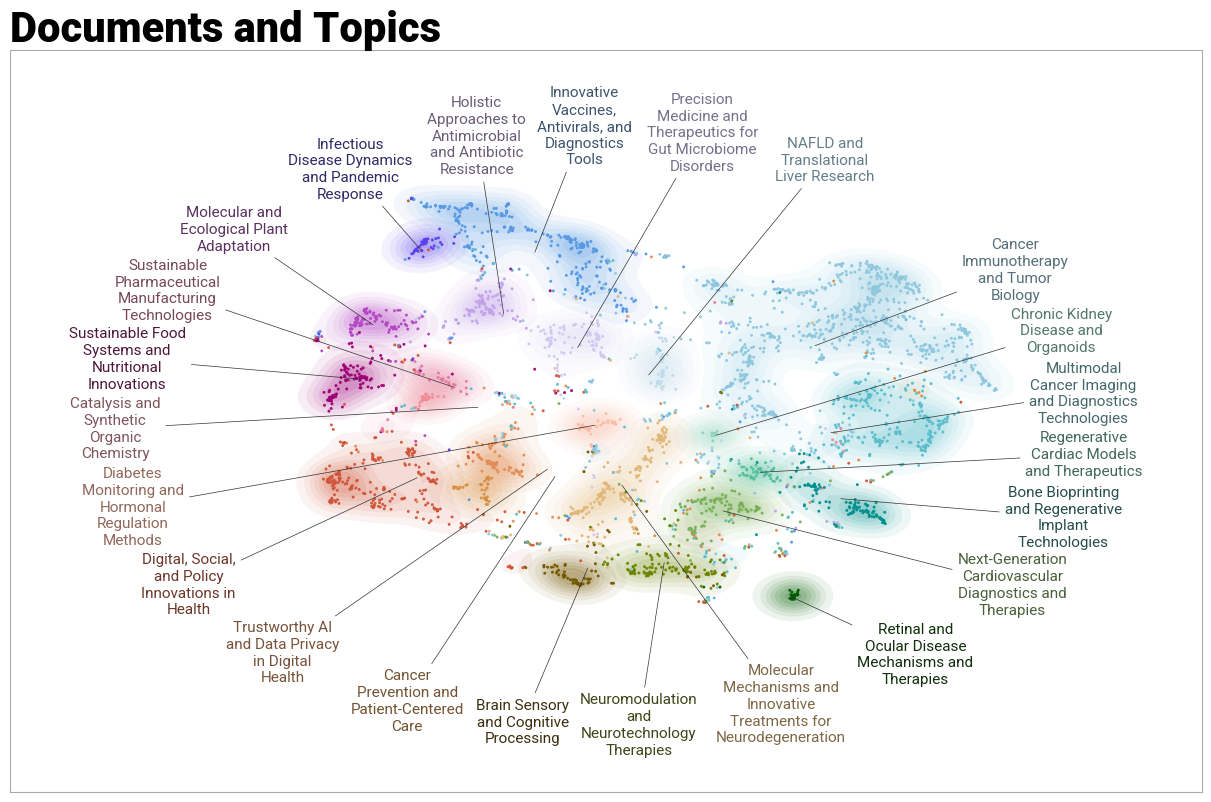

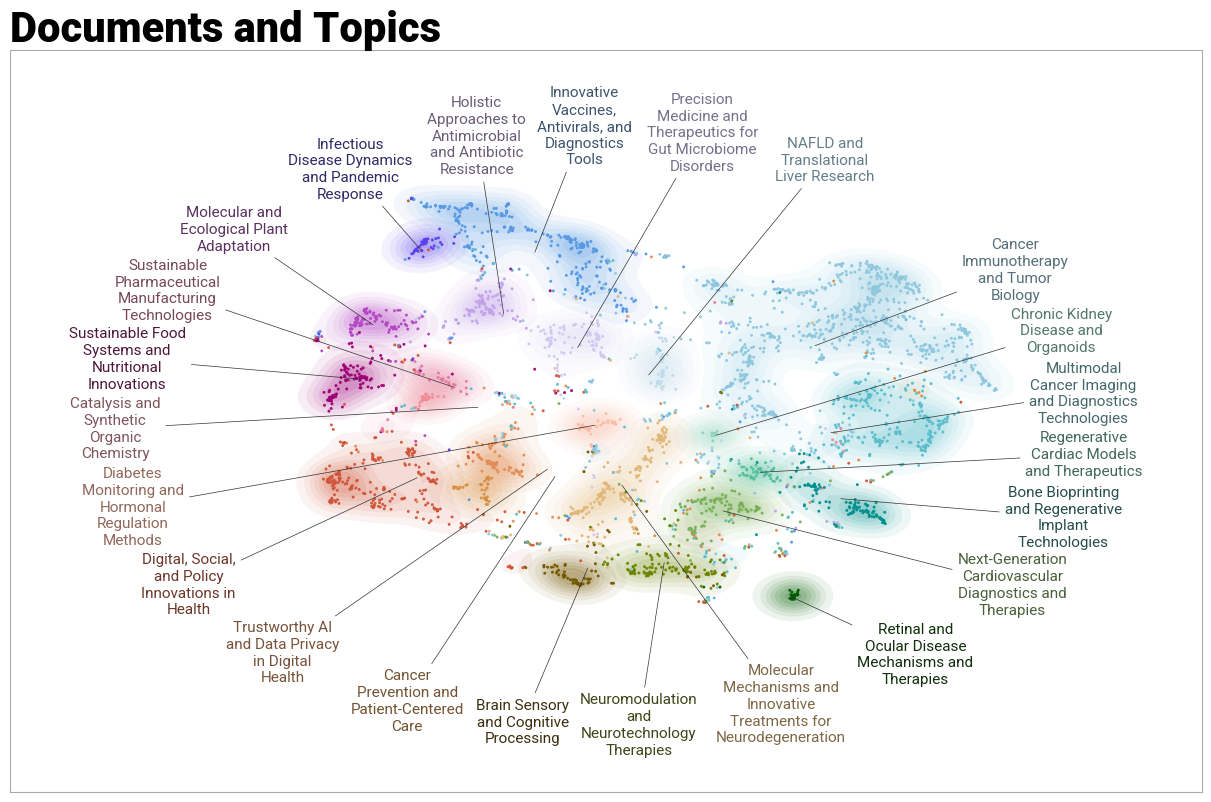

In [47]:
topic_model.visualize_document_datamap(
    titles,
    custom_labels=True,
    reduced_embeddings=reduced_embeddings,
    datamap_kwds={"label_font_size": 11, "label_linespacing": 1.25, "label_margin_factor": 1.0}
)


In [36]:
hierarchical_topics = topic_model.hierarchical_topics(text)


100%|██████████| 22/22 [00:00<00:00, 240.62it/s]


In [46]:
topic_labels = topic_model.generate_topic_labels(
    nr_words=5, topic_prefix=False, word_length=10, separator=", ", aspect="KeyBERT"
)
topic_model.set_topic_labels(topic_labels)


In [36]:
topci_model.get_topic_info()

NameError: name 'topci_model' is not defined

In [23]:
import pandas as pd

topic_df = pd.DataFrame(
    {
        "projectID": health_df["projectID"],
        "title": health_df["title"],
        "abstract": health_df["objective"],
        "topic": topic_model.topics_,
    }
)
# topic_df.to_csv("data/processed/topic_df.csv")


In [24]:
topics = topic_model.get_topic_info()
# topics.to_csv("data/processed/topics.csv")


In [1]:
topics.columns

NameError: name 'topics' is not defined

In [26]:
topic_df = pd.merge(
    topic_df,
    topics[["Topic", "Count", "MMR", "KeyBERT", "POS"]],
    left_on="topic",
    right_on="Topic",
    how="left",
)


topic_df = pd.merge(
    topic_df,
    health_df[["projectID", "euroSciVocTitle"]],
    on="projectID",
    how="left",
)

topic_df.shape


(3465, 10)

In [28]:
topic_df.drop(columns="Topic", inplace=True)
topic_df.to_csv("data/processed/topics_df.csv", index=False)


In [18]:
# or use one of the other topic representations, like KeyBERTInspired
# keybert_topic_labels = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in topic_model.topic_aspects_["KeyBERT"].items()}
# topic_model.set_topic_labels(keybert_topic_labels)

pos_topic_labels = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in topic_model.topic_aspects_["POS"].items()}
topic_model.set_topic_labels(pos_topic_labels)


In [38]:
topic_model.visualize_topics(custom_labels=True)


In [41]:
topic_model.visualize_hierarchy(custom_labels=False)


In [22]:
# `topic_distr` contains the distribution of topics in each document
topic_distr, _ = topic_model.approximate_distribution(abstracts, window=8, stride=4)


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


In [29]:
from pprint import pprint

abstract_id = 10
pprint(abstracts[abstract_id], width=80)


('BiomimX Beating organs-on-chips (OoC) are in vitro miniaturized and living '
 'replica of human organs and diseases,building upon cutting-edge technologies '
 'and human cells. Beating OoC provide a faithful replication of native '
 'humanphysiology integrating miniaturized 3D cell culture techniques, '
 'mechanical stimulation (uBeat®) and electrical recordingcapabilities '
 '(uSense). BiomimX’s proprietary key technology (uBeat®) supports 3D human '
 'cell cultures and integrates acontrolled and tunable mechanical stimulation '
 'system. uBeat® leads to the generation of mature and functional '
 'miniaturizedreplication of human organs adequate to test compounds '
 'toxicity/functionality in a high-throughput fashion. Integration ofuSense '
 'allows real-time evaluation of clinically relevant parameters from the '
 'established beating models. BiomimX’sBeating OoC represent a safer, more '
 'efficient and faster alternative to poorly predictable preclinical models to '
 'date avail

In [24]:
# Visualize the topic-document distribution for a single document
topic_model.visualize_distribution(topic_distr[abstract_id])


In [25]:
# Visualize the topic-document distribution for a single document
topic_model.visualize_distribution(topic_distr[abstract_id], custom_labels=True)


In [ ]:
# Calculate the topic distributions on a token-level
# topic_distr, topic_token_distr = topic_model.approximate_distribution(abstracts, use_embedding_model=True)

# Visualize the token-level distributions
# df = topic_model.visualize_approximate_distribution(abstracts[abstract_id], topic_token_distr[0])
# df


In [42]:
# Reduce outliers
new_topics = topic_model.reduce_outliers(abstracts, topics)

# Reduce outliers with pre-calculate embeddings instead
new_topics = topic_model.reduce_outliers(abstracts, topics, strategy="embeddings", embeddings=embeddings)


100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


In [43]:
topic_model.update_topics(abstracts, topics=new_topics)


2025-05-21 08:41:51,380 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
topic_model.get_topic_info()


,Topic,Count,Name,Representation,KeyBERT,Flan-t5,MMR,POS,Representative_Docs
0,0,1077,0_the_of_and_to,"[the, of, and, to, in, cancer, will, for, is, ...","[cancer cells, tumors, metastatic, tumour, can...","[IPSIRIUS, , , , , , , , , ]","[cancer, cells, patients, project, immune, res...","[cancer, cell, cells, tumor, treatment, patien...",[Novel cancer molecular-targeted therapies all...
1,1,378,1_and_the_of_to,"[and, the, of, to, in, will, for, with, is, by]","[sars cov, sars, covid 19, viruses, antiviral,...",[Virus: Virus: Virus: Virus: Virus: Virus: Vir...,"[vaccine, malaria, viruses, immune, vaccines, ...","[viral, virus, vaccine, malaria, viruses, infe...",[Lower respiratory tract infections resulting ...
2,2,204,2_the_of_and_in,"[the, of, and, in, ad, to, brain, disease, wil...","[microglia, neuroinflammation, neurodegenerati...",[human microglia transduce toxicity to neurons...,"[dementia, microglia, neurodegenerative, alzhe...","[disease, brain, dementia, protein, neurodegen...",[The recently approved drugs for Alzheimers di...
3,3,189,3_the_and_of_to,"[the, and, of, to, in, heart, cardiac, for, is...","[cardiomyocytes, myocardial, cardiac, cardiova...","[novel bioprinting for cardiac fibrosis, , , ,...","[heart, cardiac, patients, cardiovascular, str...","[heart, cardiac, patients, clinical, cardiovas...",[Cardiovascular diseases (CVDs) are the leadin...
4,4,195,4_and_the_of_to,"[and, the, of, to, in, on, social, health, wil...","[eu, europe, european, crises, 19 pandemic, pa...","[REGROUP: resiliency, , , , , , , , , ]","[social, project, research, policy, covid, wom...","[social, political, health, pandemic, project,...",[RECOVER-GEU presents an innovative gendered p...
5,5,135,5_the_of_and_to,"[the, of, and, to, in, resistance, antibiotics...","[antimicrobial resistance, antibiotic resistan...","[Antimicrobial resistance, , , , , , , , , ]","[antibiotics, antibiotic, antimicrobial, bacte...","[antibiotics, resistance, antibiotic, antimicr...",[The emergence of Gram-negative bacterial resi...
6,6,187,6_the_and_of_to,"[the, and, of, to, in, for, bone, is, will, with]","[bone regeneration, bioprinting, tissue engine...","[BioForceInk: bioactive reinforcing bioink, , ...","[bone, tissue, oa, implants, bioprinting, cart...","[bone, tissue, pain, mechanical, implants, bio...",[Bone fracture nonunion (FNU) is one of the le...
7,7,113,7_gut_the_and_of,"[gut, the, and, of, in, to, microbiome, ibd, w...","[gut microbiome, gut microbiota, microbiome, m...","[Inflammatory Bowel Disease, , , , , , , , , ]","[gut, ibd, microbiota, intestinal, microbiome,...","[gut, microbiota, intestinal, microbiome, host...","[The human gut microbiota, the trillions of mi..."
8,8,139,8_food_and_the_of,"[food, and, the, of, to, in, will, for, sustai...","[food systems, sustainable food, food security...","[INCiTiS-FOOD, , , , , , , , , ]","[food, sustainable, protein, food systems, nut...","[food, sustainable, protein, production, nutri...",[The agri-food industry faces numerous challen...
9,9,146,9_the_of_and_to,"[the, of, and, to, in, will, brain, for, this,...","[cortex, neural, neurons, neuronal, neuroscien...","[psychiatric, , , , , , , , , ]","[brain, neural, psychiatric, cognitive, anxiet...","[brain, neural, disorders, visual, sensory, ac...",[An organism’s survival depends on accurately ...


In [ ]:
# Visualize topics and documents
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))


In [ ]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()


In [ ]:
# Visualize relationships between topics
# topic_model.visualize_heatmap(n_clusters=30)


In [ ]:
# Visualize the potential hierarchical structure of topics
# topic_model.visualize_hierarchy()
